### Don't Rerun below (it's slow 46mins)

In [1]:
from ipynb.fs.full.yt_web import get_video_data

/Users/josegarza/opt/anaconda3/envs/ai/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-12-02 20:42:29.084553: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2022-12-02 20:42:37,297 loading file /Users/josegarza/.flair/models/sentiment-en-mix-distillbert_4.pt
2000
0    [101, 1037, 18385, 1010, 6057, 1998, 2633, 182...
1    [101, 4593, 2128, 27241, 23931, 2013, 1996, 62...
2    [101, 2027, 3653, 23545, 2037, 4378, 24185, 10...
3    [101, 2023, 2003, 1037, 17453, 14726, 19379, 1...
4    [101, 5655, 6262, 1005, 1055, 12075, 2571, 376...
Name: Comment, dtype: object
(2000, 59)
(2000, 59)
torch.Size([2000, 59]) and attention mask torch.Size([2000, 59])
0.9085
TextBlob Confusion Matrix
[[571 388]
 [292 749]]
accuracy =  0.66
Vader Confusion Matrix
[[450 509]
 [154 887]]
accuracy =  0.6685
BERT Confusion Matrix
[[880  79]
 [104 937]]
accuracy =  0.9085
Flair Confusion Matrix
[[ 941   18]
 [  23 1018]]
accuracy =  0.9795
[0.66, 0.6685, 0.9085, 0.9795]
GOOD: I love the way you explained, ...
BAD: I hate the way you explained, ...


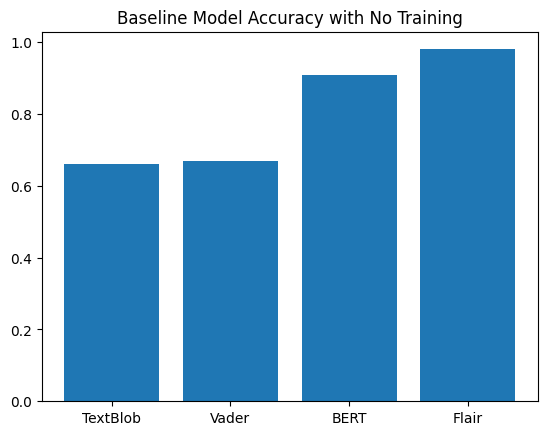

In [2]:
from ipynb.fs.full.sentiment_small import flairPredict as predict_small

In [3]:
# from ipynb.fs.full.sentiment_large import flairPredict as predict_large

In [4]:
import collections
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import re

In [5]:
videos = get_video_data()

In [6]:
tags = [1, 2, 10, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
id_to_tag =  {1:'Film & Animation',2:'Autos & Vehicles',10:'Music',15:'Pets & Animals',17:'Sports',18:'Short Movies',19:'Travel & Events',20:'Gaming',21:'Videoblogging',22:'People & Blogs',23:'Comedy',24:'Entertainment',25:'News & Politics',26:'Howto & Style',27:'Education',28:'Science & Technology',29:'Nonprofits & Activism',30:'Movies',31:'Anime/Animation',32:'Action/Adventure',33:'Classics',34:'Comedy',35:'Documentary',36:'Drama',37:'Family',38:'Foreign',39:'Horror',40:'Sci-Fi/Fantasy',41:'Thriller',42:'Shorts',43:'Shows',44:'Trailers'}
score_to_text = {0:'BAD', 1:'GOOD'}

In [7]:
sentence = "I love the way you explained, plus the diversity :)"
max_len = 30
sentence_pred = predict_small(sentence)
result = f'{score_to_text[sentence_pred]}: {sentence[:max_len]}...'
print(result)

sentence = "I hate the way you explained, plus no diversity"
sentence_pred = predict_small(sentence)
result = f'{score_to_text[sentence_pred]}: {sentence[:max_len]}...'
print(result)

GOOD: I love the way you explained, ...
BAD: I hate the way you explained, ...


### Types of charts
#### tag -> sentiment ratio Sports [40% positive]  -- compare most positive tags
#### Word blob | comments / tag (all, pos, neg)
#### each tag, have most popular topics top 5: [soccer: fifa 60% pos , messi 80% pos] [music: bts]
#### comments/view_count / tag  = how enganging is a tag 
#### word generator


In [54]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
add_stop_words = ['im','wasnt', 'lets','going', 'like', '', 'get', 'cant','dont', 'would', 'still']
add_stop_words.extend([str(i) for i in range(50)])
for w in add_stop_words:
    stop_words.add(w)

In [39]:
def top_words_per_tag():
    tags_counder = defaultdict(list)
    for v in videos.values():
        for s in v.comments:
            for w in s.split():
                w = re.sub(r'[^\w]', '', w).lower()
                if w not in stop_words and w != '':
                    tags_counder[int(v.category_id)].append(w)
    return tags_counder

def make_autopct(values):
    # autopct='%1.1f%%'
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}% ({v:d})'.format(p=pct,v=val)
    return my_autopct

def plot_top_words_per_tag(tags_counder, count):
    for t in tags:
        if t not in tags_counder:
            continue
        most_common_words_tuple = collections.Counter(tags_counder[t]).most_common(count)
        common_words, counts = [i[0] for i in most_common_words_tuple], [i[1] for i in most_common_words_tuple]
        plt.title(id_to_tag[t])
        plt.pie(counts, labels=common_words,  autopct=make_autopct(counts), textprops={'fontsize': 8})
        plt.axis('equal')
        plt.show()

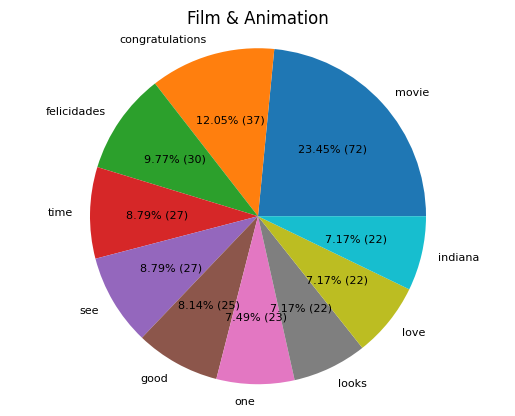

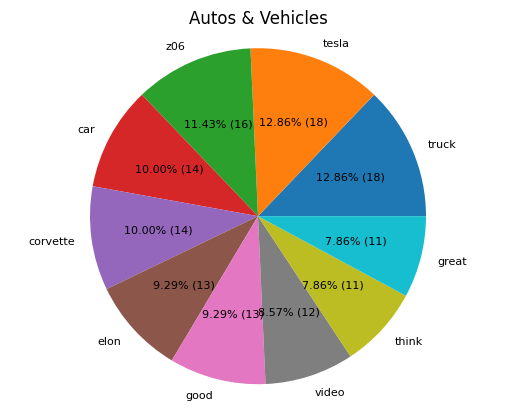

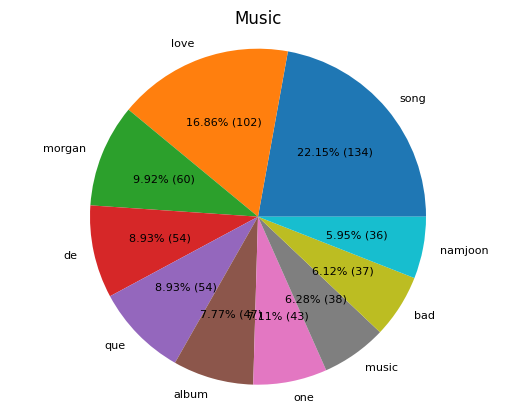

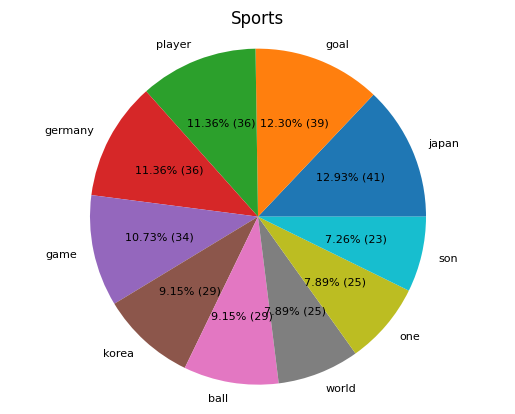

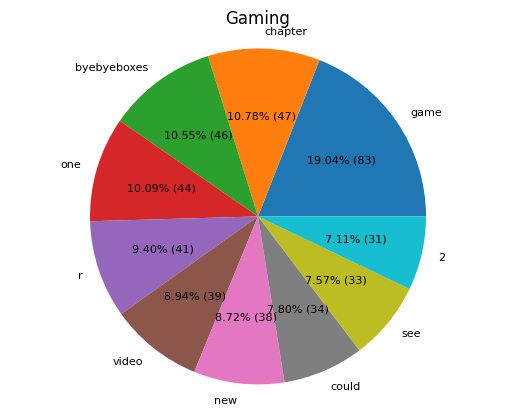

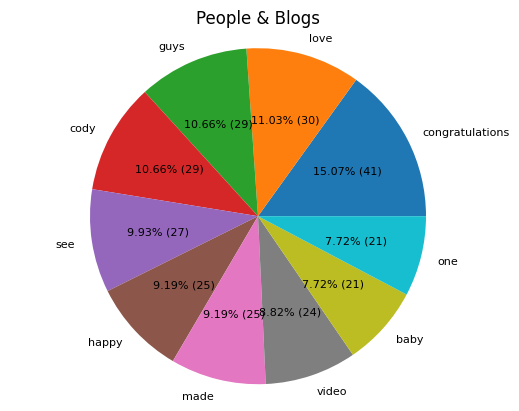

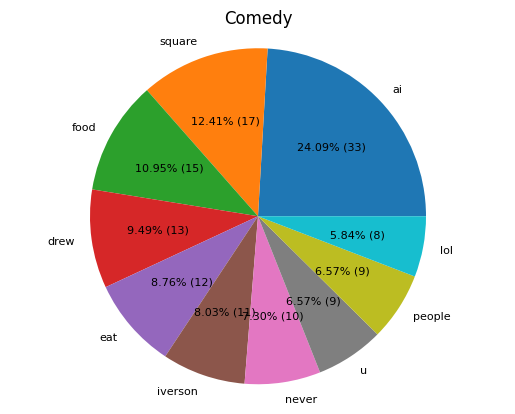

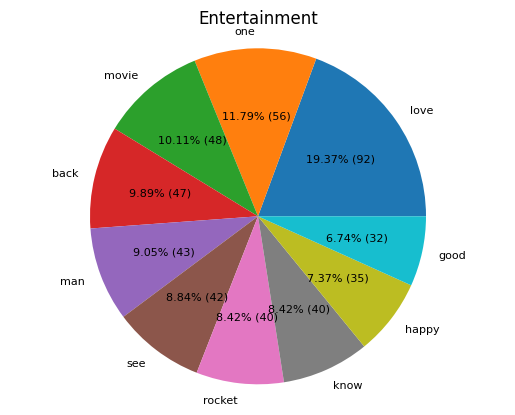

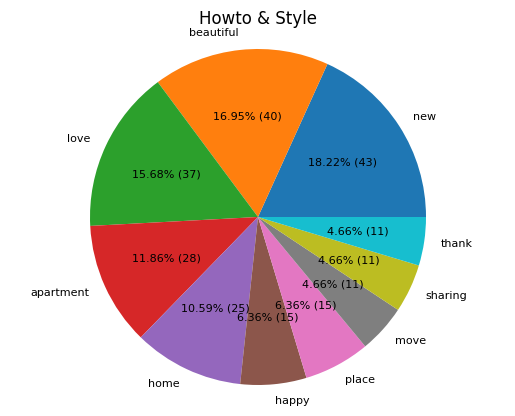

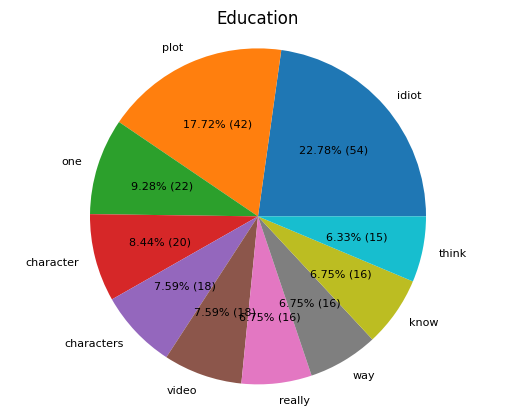

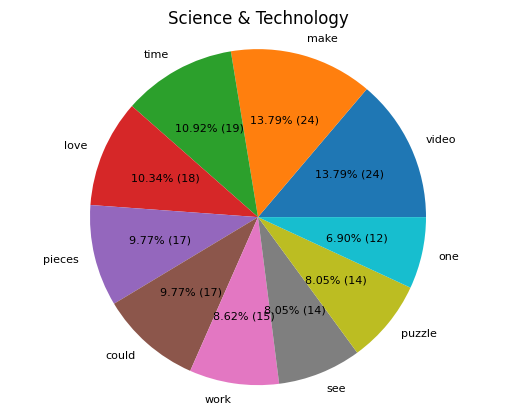

In [40]:
tags_counder = top_words_per_tag()
plot_top_words_per_tag(tags_counder, 10)

In [41]:
def sentiment_per_tag():
    tags_sent_dict = defaultdict(list)
    for v in videos.values():
        for s in v.comments:
            pred = predict_small(s)
            if int(v.category_id) not in tags_sent_dict:
                tags_sent_dict[int(v.category_id)] = {0:0,1:1} if pred else {0:1,1:0} 
            else: 
                tags_sent_dict[int(v.category_id)][pred] +=1
    return tags_sent_dict

In [55]:
def plot_sentiment_per_tag(tags_sent_dict):
    labels = [id_to_tag[v] for v in tags_sent_dict.keys()]
    pos = [val[1] for val in tags_sent_dict.values()]
    negs = [val[0] for val in tags_sent_dict.values()]
    width = 0.35       # the width of the bars: can also be len(x) sequence

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    pos_bar = ax.bar(x - width/2, pos, width, label='positive', color='tab:blue')
    neg_bar = ax.bar(x + width/2, negs, width, label='negative', color='tab:red')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Counts')
    ax.set_title('Counts of Pos/Neg per Tag')
    ax.set_xticks(x, labels)
    ax.legend()

    ax.bar_label(pos_bar, padding=3)
    ax.bar_label(neg_bar, padding=3)
    fig.tight_layout()
    plt.xticks(rotation=90)
    plt.show()

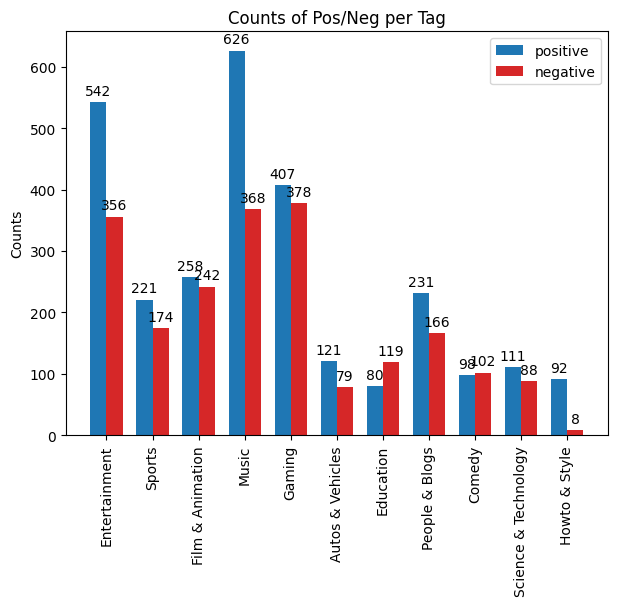

In [56]:
tags_sent_dict = sentiment_per_tag()
plot_sentiment_per_tag(tags_sent_dict)

In [44]:
def make_autopct(values):
    # autopct='%1.1f%%'
    def my_autopct(pct):
        total = sum(values)
        val = pct*total/100
        return '{p:.2f}% ({v:.2f}%)'.format(p=pct,v=val)
    return my_autopct

def plot_sentiment_rate(tags_sent_dict):
    labels = [id_to_tag[v] for v in tags_sent_dict.keys()]
    scores = [val[1]/(val[0]+val[1]) for val in tags_sent_dict.values()]
    width = 0.35       # the width of the bars: can also be len(x) sequence

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    plt.title('Ratio of postive/total sentiment - ratio% (pos/(pos+neg)%)')
    plt.pie(scores, labels=labels,  autopct=make_autopct(scores), textprops={'fontsize': 8})
    plt.axis('equal')
    plt.show()

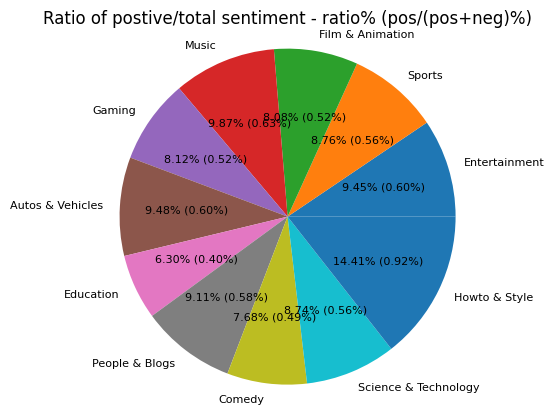

In [45]:
plot_sentiment_rate(tags_sent_dict)

In [46]:
def video_engagement_score(video):
    if video is None:
        return 0
    return float(video.comment_count) / float(video.view_count)

In [61]:
def video_tag_scores():
    tags_score = defaultdict()
    video_score = defaultdict(list)
    for v in videos.values():
        v_score = video_engagement_score(v)
        video_score[int(v.category_id)].append(v_score)

    for t in tags:
        if t in video_score:
            tags_score[t] = sum(video_score[t]) / len(video_score[t])
    return tags_score

def plot_engagement(tags_engagment):
    fig, ax = plt.subplots()
    labels = [id_to_tag[v] for v in tags_engagment.keys()]
    scores = [val for val in tags_engagment.values()]
    counts = [40, 100, 30, 55]
    bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']
    ax.bar(labels, scores, label=labels, color=bar_colors)
    ax.set_ylabel('Engagment scores comments/views')
    ax.set_title('comments/view count')
    plt.xticks(rotation=90)


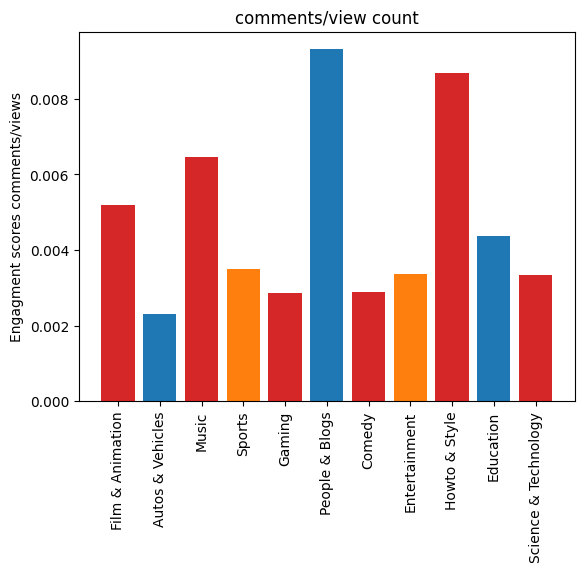

In [62]:
tags_engagment = video_tag_scores()
plot_engagement(tags_engagment)